# Overfitting
This file first extracts for each TC, the maximum intensity iamge. Then let the model overfits this small subset.<br>
The dataset sizes are:
+ train.npy: 1027, 664MB;
+ val.npy: 258, 167MB;<br>

If we want training set from all frames, then we need 
+ train.npy: $\frac{37900+18500}{1027}*664=36$GB;
+ val.npy: $\frac{47381\times0.2+23118\times0.2}{258}*167=9$GB;

# Import modules
Run 1st.

In [2]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import copy
import time
import math
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.utils.model_zoo as model_zoo
import torchvision
from torchvision import transforms, datasets, models
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.2


# Read in info and get maxes
+ YORO: You Only Run Once (can run outside in **generate.py**)
+ Saved 2 files in the current directory, all in npy file type:<br>
    1. trainInfo.npy
    2. valInfo.npy
+ Saved X files in ./data/ directory, for example
    1. train_0.npy
    2. val_0.npy

## Write data into files
Run the external **generate.py** file. Need to have enough space in the subfolder.

In [ ]:
! run generate.py

## Agregation for mean and std
Results are not good. Only 60% pixels are valid and std calculations are always problematic.<br>
Numbers calculated are way off from the max samples.<br>
Try without transformation learning and using the old mean and std.

In [20]:
assert len([f for f in os.listdir('./data/') if os.path.isfile(os.path.join('./data/', f)) and f.split('_')[0] == 'train']) \
== 63448
assert len([f for f in os.listdir('./data/') if os.path.isfile(os.path.join('./data/', f)) and f.split('_')[0] == 'val']) \
== 7051

In [21]:
# initialize
total = np.zeros(4)
sqd = np.zeros(4)
invalidCount = 0

# only look at training files
for f in os.listdir('./data/'):
    if os.path.isfile(os.path.join('./data/', f)) and f.split('_')[0] == 'train':
        local = np.load(os.path.join('./data/', f))
        assert local.shape == (201, 201, 4)
        # count for nan
        invalidCount += np.sum(np.isnan(local), axis = (0,1)) / (201 * 201)
        local = np.nan_to_num(local)
        # count for large values
        invalidCount += np.sum(local > 1000, axis = (0,1)) / (201 * 201)
        local[local > 1000] = 0
        # aggregate
        total += np.sum(local, axis = (0,1)) / (201 * 201)
        sqd +=  np.sum(local ** 2, axis = (0,1)) / (201 * 201)

In [22]:
print(total)
print(sqd)

validCount = 1 - invalidCount / 63448
print(validCount)

EX = np.divide(total, validCount) / 63448
EX2 = np.divide(sqd, validCount) / 63448

var = EX2 - EX ** 2
std = var ** 0.5
print(EX, std)

# Output:
# [16854908.97608781 14874123.11677265    18906.99085228    30709.80710016]
# [4.56024219e+09 3.51995570e+09 2.89435860e+04 1.52275582e+05]
# [0.99190287 0.99318325 0.60862571 0.99386821]
# [267.81773236 236.03915245   0.4896144    0.48700156] [27.09388376 12.00400448  0.71400228  1.47568378]

# infomation to use
# EX, std
# [267.81773236 236.03915245   0.4896144    0.48700156] [27.09388376 12.00400448  0.71400228  1.47568378]

# should be around
# (207.02715, 0.53710043),
# (58.167034,  1.552934)

[16854908.97608781 14874123.11677265    18906.99085228    30709.80710016]
[4.56024219e+09 3.51995570e+09 2.89435860e+04 1.52275582e+05]
[0.99190287 0.99318325 0.60862571 0.99386821]
[267.81773236 236.03915245   0.4896144    0.48700156] [27.09388376 12.00400448  0.71400228  1.47568378]


# Models: defining and training
If we are loading data from npy files, then a np.moveaxis() is needed.

## kddTC: regression

### kddTC: model

In [ ]:
'''
Notice data fed to kddTC should follow the pre-processing steps by the paper
Especially, (1) only two channels should be included;
(2) middle cropping;
(3) rotation?
'''
class kddAlex(nn.Module):

    def __init__(self, num_outputs = 1):
        super(kddAlex, self).__init__()
        ###
        ### Changed 3 to 2 to fit our data dimension sieze
        ###
        self.features = nn.Sequential(
            # nn.Conv2d(2, 64, kernel_size=11, stride=4, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(2, 16, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # nn.Dropout(),
            # linear: 2 * 64 * 64, 256
            # conv: 128 * 3 * 3, 256
            nn.Linear(128 * 3 * 3, 256), 
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_outputs),
        )

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        # linear: 2 * 64 * 64
        # conv: 128 * 3 * 3
        x = x.view(x.size(0), 128 * 3 * 3)
        x = self.classifier(x)
        return x


def kddTC(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = kddAlex(**kwargs)
    return model


### kddTCData: Dataset object
+ 2 channels;
+ middle crop 64
+ nan and extreme large treatment to 0

In [ ]:
class kddTCData(data.Dataset):

    def __init__(self, dataPath, infoPath, transform=None):
        super(kddTCData, self).__init__()
        # load data from npy file
        self.data = np.load(dataPath)
        # load label from h5 file with pandas dataframe
        h5_file = h5py.File(infoPath)
        self.target = h5_file['info/block0_values'][:,2]
        # transform as defined outside
        self.transform = transform

    def __getitem__(self, index):
        # middle crop and permute axis
        # we found that in the later cell, there is a "center crop" transform
        # if the transforms.centercrop() works, then no need for 68:(68+64)
        datMatrix = torch.from_numpy(np.moveaxis(self.data[index, 68:(68+64), 68:(68+64), [0,3]], 0, -1)).float()
        datMatrix = np.nan_to_num(datMatrix)
        datMatrix[datMatrix > 1000] = 0
#         print(index)
        # print(datMatrix.shape)
        if self.transform:
            datMatrix = self.transform(datMatrix)
        
        labMatrix = torch.from_numpy(self.target)[index].float()
        
        return (datMatrix, labMatrix)

    def __len__(self):
        return self.data.shape[0]

### Prepare for learning
+ Transformation;
+ Data set object;
+ Dataloaders of datasets;
+ Criterion in loss;

In [ ]:
transf = {
    'mean': (207.02715, 0.53710043),
    'std': (58.167034,  1.552934)
}

data_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=transf['mean'], std=transf['std']) 
    # transforms.CenterCrop(64)
])

datasets = {x: kddTCData('{}.npy'.format(x), '{}Info.h5'.format(x), data_transform)
            for x in ['train', 'val']}
dataloaders = {x: DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()

### Train function: regression
Train model with MSE loss.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    # best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    val_loss = 0
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step(val_loss)
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    print('Epoch: {}\n'.format(epoch))
                    print('Outputs: {}\n'.format(outputs))
                    print('Labels: {}\n'.format(labels))
                    # _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss = epoch_loss
                val_loss_history.append(val_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_loss_history

### kdd18: training and output curve

In [ ]:
kdd18 = kddTC(pretrained=False)
kdd18 = kdd18.to(device)

optimizer = optim.Adam(kdd18.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
#                                                  patience = 5, threshold = 0.01, 
#                                                  factor = 1/3, threshold_mode  = 'rel')
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)

_, val_loss, train_loss = train_model(kdd18, criterion, optimizer, scheduler, num_epochs=50)


In [ ]:
plt.plot(val_loss, label = 'val')
plt.plot(train_loss, label = 'train')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
# plt.title('Losses curve on (500 *0.7) training dataset')
plt.legend()
plt.show()

### Why is it performing so badly?
Plot IR channel of the dataset. Okay, the preprocessing did what it claimed.
    + nan to number 0;
    + large values (>1000) to 0;

In [ ]:
train = np.load('train.npy')
trainInfo = h5py.File('trainInfo.h5')
trainInfo = trainInfo['info/block0_values'][:,2]

val = np.load('val.npy')
valInfo = h5py.File('valInfo.h5')
valInfo = valInfo['info/block0_values'][:,2]

def show(train, trainInfo):
    # print(trainInfo[number])
    dic = {1027: 'train', 258: 'val'}
    for number in range(train.shape[0]):
        d = np.nan_to_num(train[number,:,:,0])
        d[d > 1000] = 0
        plt.imshow(d, cmap='gray')
        plt.text(10, 10, trainInfo[number])
        plt.savefig('figures/{}{}'.format(dic[train.shape[0]], number))
        plt.close()
show(train, trainInfo)
show(val, valInfo)

In [ ]:
plt.imshow(np.isnan(val[49, :, :, 0]), cmap = 'gray')
plt.show()

In [ ]:
plt.imshow(val[49, :, :, 0], cmap='gray')
# plt.text(10, 10, trainInfo[number])
plt.show()

In [ ]:
plt.hist(val[49, :, :, 0].flatten(), 20)
plt.show()

In [ ]:
x = np.nan_to_num(val[49, :, :, 0])
print(np.max(x))
print(x[0,0])

In [ ]:
plt.imshow(x, cmap='gray', vmax=255, vmin=0)
# plt.text(10, 10, trainInfo[number])
plt.show()

In [ ]:
x[0,0]

In [ ]:
plt.hist(x.flatten(), 50)
plt.show()

In [ ]:
x[x>1000] = 0

In [ ]:
plt.imshow(x, cmap='gray')
# plt.text(10, 10, trainInfo[number])
plt.show()

In [ ]:
plt.hist(x.flatten(), 20)
plt.show()

## kddTC: classification

### kddTC: model

In [26]:
'''
Notice data fed to kddTC should follow the pre-processing steps by the paper
Especially, (1) only two channels should be included;
(2) middle cropping;
(3) rotation?
'''
class kddAlex(nn.Module):

    def __init__(self, num_outputs = 8):
        super(kddAlex, self).__init__()
        ###
        ### Changed 3 to 2 to fit our data dimension sieze
        ###
        self.features = nn.Sequential(
            # nn.Conv2d(2, 64, kernel_size=11, stride=4, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(2, 16, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # nn.Dropout(),
            # linear: 2 * 64 * 64, 256
            # conv: 128 * 3 * 3, 256
            nn.Linear(128 * 3 * 3, 256), 
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_outputs),
        )

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        # linear: 2 * 64 * 64
        # conv: 128 * 3 * 3
        x = x.view(x.size(0), 128 * 3 * 3)
        x = self.classifier(x)
        return x


def kddTC(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = kddAlex(**kwargs)
    return model


### kddTCData: Dataset object
+ label;
+ 2 channels;
+ middle crop 64
+ nan and extreme large treatment to 0

In [43]:
class kddTCData(data.Dataset):

    def __init__(self, dataPath, infoPath, transform=None):
        super(kddTCData, self).__init__()
        # load data from npy file
        self.data = np.load(dataPath)
        # load label from h5 file with pandas dataframe
        self.target = np.load(infoPath)
        # transform as defined outside
        self.transform = transform
        self.targetDic = {
            'no':0, 'td':1, 'ts':2, 'one':3, 'two':4, 'three':5, 'four':6, 'five':7
        }

    def __getitem__(self, index):
        # middle crop and permute axis
        # we found that in the later cell, there is a "center crop" transform
        # if the transforms.centercrop() works, then no need for 68:(68+64)
        datMatrix = torch.from_numpy(np.moveaxis(self.data[index, 68:(68+64), 68:(68+64), [0,3]], 0, -1)).float()
        datMatrix = np.nan_to_num(datMatrix)
        datMatrix[datMatrix > 1000] = 0
#         print(index)
        # print(datMatrix.shape)
        if self.transform:
            datMatrix = self.transform(datMatrix)
        
        labMatrix = self.target[index]
        
        return (datMatrix, labMatrix)

    def __len__(self):
        return self.data.shape[0]

### Prepare for learning
+ Transformation;
+ Data set object;
+ Dataloaders of datasets;
+ Criterion in loss;

In [45]:
trainData = np.load('train.npy')
transf = {
    'mean': (207.02715, 0.53710043),
    'std': (58.167034,  1.552934)
}

data_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=transf['mean'], std=transf['std']) 
    # transforms.CenterCrop(64)
])

# old info files are in .h5
# new are in npy
datasets = {x: kddTCData('{}.npy'.format(x), '{}Info.npy'.format(x), data_transform) 
            for x in ['train', 'val']}
dataloaders = {x: DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

### Train function: classification
Train model with cross entropy loss (or equivalently, softmax loss).

In [55]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #print(outputs, loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                print(preds)
                print(labels.data)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                training_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_acc

### kdd18: learning

In [57]:
labels = ['no', 'td', 'ts', 'one', 'two', 'three', 'four', 'five']
kdd18 = kddTC(pretrained=False)
kdd18 = kdd18.to(device)

optimizer = optim.Adam(kdd18.parameters(), lr=0.01, weight_decay=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
#                                                  patience = 5, threshold = 0.01, 
#                                                  factor = 1/3, threshold_mode  = 'rel')
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)

_, train_acc = train_model(kdd18, criterion, optimizer, scheduler, num_epochs=50)


Epoch 0/49
----------
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4])
tensor([5, 2, 2, 5, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 5, 1, 2, 2, 6, 3, 6, 3,
        5, 2, 3, 4, 2, 2, 6, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 7, 7, 7, 3, 2, 6, 3, 7, 2, 6, 5, 2, 6, 3, 2, 2, 2, 2, 4, 6, 6, 2, 2,
        2, 7, 3, 5, 5, 2, 6, 3])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])
tensor([3, 7, 2, 2, 6, 7, 2, 6, 2, 2, 2, 5, 2, 5, 5, 3, 6, 6, 2, 2, 1, 6, 2, 7,
        6, 6, 1, 3, 3, 5, 3, 1])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])
tensor([5, 3, 2, 2, 6, 2, 2, 2, 1, 4, 4, 3, 6, 6, 3, 2, 4, 1, 4, 6, 1, 3, 3, 4,
        2, 2, 2, 3, 2, 2, 2, 3])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 3, 2, 5, 2, 2, 2, 3, 6, 6, 4, 2, 2, 5, 2, 2, 3, 2, 3, 1, 2, 7, 7,
        3, 6, 7, 3, 5, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 5, 2, 5, 6, 5, 2, 6, 3, 2, 2, 2, 2, 6, 2, 5, 2, 5, 3, 2, 6, 1, 5, 3,
        6, 6, 6, 7, 6, 2, 1, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 2, 7, 2, 6, 3, 1, 3, 3, 1, 2, 1, 7, 2, 1, 6, 2, 2, 1, 5, 2, 2, 1, 3,
        3, 7, 2, 1, 1, 2, 6, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 3, 2, 5, 7, 3, 6, 2, 2, 6, 6, 6, 4, 5, 2, 2, 4, 6, 6, 6, 4, 2, 2, 3,
        2, 2, 2, 2, 2, 5, 2, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 2, 2, 2, 4, 3, 2, 2, 6, 3, 6, 1, 2, 6, 1, 1, 4, 5, 3, 5, 3, 2, 5,
        4, 5, 1, 1, 2, 1, 2, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 2, 3, 6, 2, 3, 2, 2, 2, 2, 2, 3, 7, 2, 2, 2, 2, 2, 2, 7, 6, 7, 3,
        3, 3, 2, 5, 2, 2, 2, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 4, 7, 7, 2, 2, 1, 6, 2, 1, 3, 6, 3, 2, 1, 1, 3, 5, 5, 2, 1, 2, 1, 6,
        7, 5, 2, 4, 3, 6, 7, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 1, 3, 3, 2, 6, 6, 2, 6, 3, 5, 4, 2, 5, 1, 1, 6, 1, 6, 6, 2, 6, 6,
        7, 1, 2, 1, 7, 2, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 5, 4, 2, 2, 5, 3, 3, 4, 3, 2, 3, 5, 3, 2, 2, 3, 2, 2, 2, 2, 6, 7,
        2, 2, 7, 1, 6, 2, 6, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 3, 3, 6, 2, 2, 2, 3, 2, 4, 3, 2, 6, 2, 1, 5, 1, 5, 4, 3, 4, 2, 4,
        7, 1, 6, 2, 2, 2, 4, 3])
tensor([2, 2])
tensor([2, 3])
val Loss: 1.7131 Acc: 0.4147

Epoch 3/49
----------
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 2, 6, 1, 6, 1, 2, 5, 2, 6, 2, 6, 3, 2, 1, 2, 4, 6, 2, 7, 4, 4, 6,
        1, 2, 2, 5, 2, 5, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 3, 6, 2, 2, 2, 4, 2, 4, 3, 2, 3, 2, 6, 2, 2, 5, 4, 3, 3, 6, 7, 2, 3,
        4, 6, 3, 2, 4, 6, 2, 4])
tensor([2, 2, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 6, 4, 3, 2, 6, 3, 2, 5, 2, 7, 6, 3, 4, 7, 2, 2, 2, 4, 1,
        4, 2, 2, 4, 2, 2, 7, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 4, 5, 5, 2, 2, 6, 2, 6, 3, 7, 2, 6, 6, 6, 2, 6, 1, 1, 3, 6, 5, 3,
        6, 6, 7, 3, 1, 3, 3, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 1, 1, 2, 2, 2, 5, 3, 1, 6, 2, 6, 4, 2, 3, 5, 7, 6, 6, 1, 5, 4, 2, 2,
        3, 2, 2, 2, 6, 5, 4, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 3, 2, 2, 2, 2, 3, 2, 1, 3, 4, 2, 5, 3, 2, 4, 2, 5, 2, 2, 3, 2, 6, 3,
        3, 2, 2, 6, 6, 1, 2, 1])
tensor([2, 2])
tensor([7, 2])
val Loss: 1.7157 Acc: 0.4147

Epoch 4/49
----------
tensor([2, 2, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 5, 2, 4, 2, 2, 2, 3, 7, 1, 2, 3, 3, 2, 2, 6, 2, 3, 2, 1, 5, 7, 1, 3,
        5, 3, 2, 2, 7, 4, 2, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 5, 6, 3, 2, 2, 7, 4, 2, 2, 2, 6, 2, 6, 2, 7, 1, 1, 5, 1, 6, 6, 1,
        2, 4, 2, 3, 6, 6, 4, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 5, 2, 4, 6, 1, 6, 2, 3, 6, 2, 2, 4, 5, 6, 2, 2, 2, 5, 2, 2, 2, 2,
        2, 6, 6, 5, 3, 2, 2, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 1, 7, 3, 1, 1, 2, 2, 2, 2, 6, 2, 1, 2, 4, 7, 2, 5, 2, 2, 3, 2,
        3, 2, 3, 4, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 3, 6, 2, 2, 3, 6, 2, 2, 2, 1, 3, 2, 2, 2, 2, 3, 6, 1, 2, 3, 6, 2,
        5, 2, 3, 1, 3, 3, 3, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 6, 7, 7, 1, 1, 2, 3, 7, 6, 5, 6, 2, 4, 2, 2, 3, 2, 2, 3, 1, 7, 2,
        3, 5, 5, 2, 1, 2, 2, 6])
tensor([2, 2, 2])
tensor([2, 1, 2])
train Loss: 1.6808 Acc: 0.4216
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 1, 2, 2, 2, 3, 3, 6, 1, 6, 2, 2, 2, 2, 3, 6, 6, 6, 2, 4, 2, 2, 7, 4,
        5, 2, 4, 2, 2, 1, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 4, 2, 7, 4, 2, 2, 1, 2, 2, 2, 2, 5, 2, 2, 5, 2, 6, 2, 1, 2, 7, 2, 2,
        7, 1, 6, 4, 2, 3, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 6, 3, 2, 6, 7, 1, 6, 2, 3, 3, 2, 3, 1, 1, 4, 6, 6, 5, 2, 3, 1, 5, 2,
        6, 3, 7, 2, 5, 6, 2, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 2, 6, 2, 6, 3, 2, 6, 1, 2, 6, 2, 3, 3, 6, 6, 6, 7, 3, 6, 2, 3, 7, 2,
        2, 3, 2, 7, 6, 4, 5, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 2, 5, 5, 4, 6, 2, 6, 7, 1, 2, 7, 7, 6, 6, 3, 6, 3, 7, 4, 2, 3, 5, 1,
        5, 2, 2, 3, 6, 2, 1, 6])
tensor([2, 2, 2])
tensor([2, 1, 2])
train Loss: 1.6754 Acc: 0.4216
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 5, 6, 2, 1, 2, 2, 1, 6, 1, 2, 2, 3, 3, 3, 6, 2, 5, 5, 2, 2,
        4, 3, 2, 6, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 1, 3, 3, 1, 3, 2, 4, 2, 3, 2, 3, 2, 3, 2, 1, 2, 4, 3, 3, 2, 2,
        6, 6, 4, 5, 2, 6, 2, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 1, 2, 6, 2, 2, 5, 2, 4, 2, 6, 2, 3, 5, 2, 2, 2, 2, 3, 5, 2, 6, 1,
        6, 6, 2, 2, 2, 2, 2, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 5, 2, 2, 2, 2, 2, 2])
tensor([1, 3, 2, 2, 6, 6, 1, 2, 1, 1, 2, 7, 2, 6, 6, 2, 2, 2, 6, 2, 3, 5, 2, 3,
        5, 5, 6, 5, 2, 2, 3, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 1, 6, 6, 3, 2, 2, 5, 2, 2, 2, 7, 3, 2, 2, 2, 1, 3, 1, 1, 1, 5,
        6, 3, 7, 2, 3, 1, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 1, 5, 2, 2, 6, 6, 2, 3, 6, 6, 2, 2, 2, 6, 3, 3, 2, 2, 3, 4, 6, 2, 1,
        6, 6, 2, 3, 6, 1, 5, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 3, 2, 1, 2, 2, 2, 5, 2, 1, 3, 2, 3, 5, 2, 2, 3, 4, 3, 5, 1, 7, 4, 2,
        1, 6, 2, 2, 4, 1, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 6, 3, 6, 2, 6, 1, 2, 2, 2, 2, 2, 2, 6, 2, 7, 2, 2, 6, 7, 2, 1, 1, 2,
        1, 3, 6, 3, 2, 2, 5, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 7, 3, 6, 5, 4, 4, 2, 2, 3, 6, 1, 2, 2, 6, 2, 6, 3, 5, 5, 2, 2, 6, 2,
        3, 2, 2, 5, 2, 6, 2, 5])
tensor([2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 5,

tensor([1, 5, 6, 5, 3, 2, 2, 2, 2, 3, 2, 2, 3, 4, 2, 7, 3, 2, 2, 7, 2, 2, 1, 7,
        6, 2, 2, 5, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 3, 2, 4, 2, 2, 2, 6, 2, 1, 2, 2, 2, 7, 1, 2, 2, 4, 2, 7, 2, 2, 3,
        5, 2, 2, 6, 3, 2, 6, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 5, 3, 1, 6, 3, 5, 2, 3, 1, 2, 2, 6, 2, 3, 1, 2, 3, 1, 7, 2, 4, 3, 3,
        2, 2, 1, 3, 2, 5, 4, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 3, 3, 5, 5, 3, 2, 6, 6, 1, 2, 2, 2, 4, 1, 1, 2, 2, 3, 6, 1, 7,
        4, 6, 2, 2, 2, 2, 5, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 3, 7, 2, 6, 4, 6, 2, 2, 7, 5, 2, 1, 2, 1, 6, 7, 2, 2, 1, 6, 5,
        6, 2, 1,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 6, 2, 2, 2, 3, 4, 2, 3, 6, 2, 2, 3, 2, 1, 6, 2, 2, 6, 2, 2, 6, 2, 5,
        2, 3, 6, 6, 6, 2, 2, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 1, 7, 4, 3, 5, 6, 6, 2, 7, 6, 2, 3, 2, 6, 2, 2, 5, 6, 2, 2, 3,
        2, 2, 5, 1, 4, 2, 6, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 1, 5, 3, 2, 2, 3, 1, 6, 2, 2, 2, 5, 2, 2, 1, 6, 2, 6, 6, 3, 2, 6,
        2, 2, 6, 2, 2, 1, 2, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 3, 2, 2, 2, 5, 2, 5, 3, 2, 2, 3, 3, 5, 6, 2, 2, 6, 2, 1, 2, 6, 5,
        2, 3, 2, 7, 4, 7, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 2, 1, 2, 3, 1, 2, 3, 2, 2, 2, 2, 3, 2, 7, 2, 2, 4, 7, 3, 2, 2, 1, 2,
        5, 6, 2, 2, 5, 3, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 6, 2, 1, 3, 2, 6, 5, 2, 2, 2, 2, 1, 6, 2, 2, 4, 3, 7, 4, 3, 1, 2, 2,
        2, 2, 6, 5, 2, 2, 1, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 2, 2, 2, 2, 6, 2, 5, 2, 1, 2, 6, 2, 2, 2, 7, 5, 2, 6, 2, 1, 2, 4,
        1, 1, 6, 3, 6, 2, 5, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 3, 6, 1, 2, 2, 2, 7, 4, 5, 2, 1, 3, 2, 3, 6, 4, 1, 2, 2, 6, 1,
        2, 2, 2, 7, 2, 3, 6, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 2, 3, 2, 2, 7, 3, 4, 2, 2, 2, 6, 4, 2, 6, 2, 6, 2, 2, 3, 3, 5,
        5, 2, 2, 7, 4, 3, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 3, 1, 5, 2, 2, 2, 3, 3, 2, 2, 2, 2, 1, 6, 6, 7, 6, 1, 2, 5, 5, 1, 3,
        4, 2, 5, 3, 4, 1, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 6, 1, 5, 2, 6, 2, 2, 6, 2, 2, 2, 4, 2, 5, 6, 4, 2, 2, 6, 2, 2,
        4, 2, 4, 1, 2, 6, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 7, 2, 2, 2, 1, 5, 3, 6, 2, 1, 5, 2, 4, 6, 2, 6, 2, 2, 4, 6, 4, 7, 2,
        2, 3, 2, 2, 2, 7, 1, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 2, 6, 1, 5, 6, 2, 6, 6, 6, 2, 2, 1, 6, 2, 2, 3, 3, 3, 1, 7, 2, 3, 4,
        2, 1, 1, 2, 1, 2, 1, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 3, 2, 2, 6, 1, 4, 6, 2, 4, 5, 3, 6, 2, 6, 2, 2, 2, 7, 5, 2, 5, 3, 2,
        2, 2, 6, 2, 7, 2, 3, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 6, 2, 3, 6, 7, 2, 3, 2, 6, 2, 2, 6, 3, 2, 6, 5, 2, 6, 2, 2, 2, 2, 2,
        6, 3, 2, 1, 4, 2, 2, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 3, 4, 4, 2, 1, 2, 7, 6, 3, 4, 2, 3, 3, 3, 6, 1, 3, 3, 3, 2, 3, 2,
        4, 2, 5, 2, 3, 2, 4, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 3, 6, 2, 1, 7, 6, 5, 2, 2, 3, 5, 2, 2, 2, 5, 4, 6, 6, 2, 2, 2, 6,
        3, 2, 2, 2, 3, 2, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 5, 3, 6, 2, 6, 2, 3, 2, 3, 2, 1, 2, 6, 2, 4, 2, 2, 3, 5, 2, 2, 2, 2,
        4, 2, 7, 2, 5, 1, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 5, 2, 2, 5, 2, 2, 3, 2, 2, 7, 6, 6, 5, 7, 2, 3, 2, 2, 2, 1, 6, 3,
        2, 7, 2, 7, 6, 3, 6, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 6, 2, 3, 2, 4, 3, 3, 7, 2, 7, 7, 5, 3, 7, 3, 2, 5, 3, 6, 1, 2, 2, 2,
        4, 3, 1, 2, 2, 2, 5, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 2, 2, 2, 2, 4, 6, 2, 1, 2, 3, 2, 2, 2, 2, 2, 5, 5, 2, 6, 3, 6, 6,
        7, 4, 3, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 3, 2, 7, 2, 2, 2, 2, 1, 2, 2, 1, 6, 2, 2, 1, 6, 6, 2, 6, 2, 3, 1, 1,
        3, 6, 3, 4, 3, 6, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 3, 7, 6, 2, 1, 6, 4, 2, 2, 6, 2, 2, 4, 2, 2, 2, 2, 2, 6, 7, 3, 6,
        2, 3, 6, 2, 7, 6, 4, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 5, 6, 6, 3, 3, 2, 3, 3, 2, 3, 1, 2, 7, 2, 2, 3, 6, 6, 4, 2, 6, 2,
        3, 2, 2, 1, 1, 2, 1, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 1, 2, 3, 6, 3, 2, 2, 2, 5, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3,
        4, 2, 1, 5, 1, 6, 4, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 2, 2, 2, 3, 3, 2, 5, 6, 5, 3, 6, 2, 2, 2, 2, 7, 7, 6, 3, 2, 2, 7,
        5, 2, 4, 2, 5, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 6, 6, 5, 3, 2, 6, 1, 3, 2, 6, 2, 5, 2, 5, 2, 2, 1, 2, 5, 7,
        2, 5, 2, 2, 5, 4, 6, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 6, 7, 2, 1, 2, 2, 5, 2, 7, 6, 3, 2, 2, 6, 6, 3, 2, 2, 2, 2, 2, 6, 6,
        3, 6, 6, 7, 6, 7, 1, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 4, 5, 7, 2, 1, 5, 6, 2, 2, 7, 1, 2, 2, 2, 2, 3, 2, 2, 3, 1, 3, 2,
        2, 2, 4, 2, 2, 4, 2, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 3, 7, 2, 2, 6, 2, 2, 1, 1, 2, 1, 1, 7, 6, 1, 2, 5, 4, 2, 6, 2, 2, 3,
        4, 2, 4, 2, 6, 2, 3, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 3, 4, 2, 3, 5, 4, 2, 2, 2, 2, 3, 6, 3, 1, 7, 3, 3, 6, 1, 4, 2,
        2, 6, 2, 3, 3, 6, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 2, 3, 3, 6, 2, 4, 2, 2, 6, 2, 2, 2, 2, 1, 2, 2, 2, 6, 3, 2, 4, 3,
        2, 3, 2, 3, 3, 2, 2, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 3, 3, 2, 2, 2, 3, 2, 7, 5, 3, 2, 7, 4, 4, 2, 6, 2, 2, 6, 6, 2, 2, 4,
        2, 2, 3, 2, 2, 2, 1, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 1, 4, 2, 2, 4, 4, 5, 6, 2, 1, 2, 5, 2, 2, 6, 2, 2, 7, 2, 3, 6, 6,
        6, 6, 3, 6, 4, 2, 5, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 6, 3, 6, 2, 2, 4, 3, 2, 2, 2, 3, 1, 6, 2, 6, 2, 2, 2, 2, 2, 7, 4, 2,
        4, 2, 4, 3, 2, 3, 6, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 2, 4, 2, 2, 3, 3, 2, 2, 6, 1, 6, 6, 6, 3, 3, 6, 2, 4, 2, 5, 2, 3,
        1, 3, 6, 6, 2, 6, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 4, 2, 2, 2, 4, 6, 1, 2, 2, 3, 5, 2, 2, 5, 7, 2, 1, 3, 2, 2, 3, 1, 3,
        1, 4, 2, 2, 6, 2, 2, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 5, 6, 2, 2, 3, 4, 2, 5, 2, 3, 2, 5, 3, 1, 7, 3, 3, 3, 2, 2, 4,
        4, 6, 4, 2, 2, 2, 3, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 2, 2, 2, 2, 7, 6, 1, 2, 1, 3, 2, 1, 5, 6, 6, 1, 3, 2, 5, 5, 7, 2,
        2, 2, 7, 7, 3, 4, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 6, 2])
tensor([4, 2, 3, 6, 2, 2, 3, 2, 2, 2, 5, 6, 6, 2, 6, 7, 2, 2, 7, 2, 6, 2, 7, 5,
        2, 2, 6, 3, 6, 3, 4, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 1, 2, 2, 2, 6, 3, 3, 3, 4, 2, 2, 2, 3, 2, 1, 2, 2, 5, 4, 2, 7, 3,
        2, 4, 2, 1, 7, 2, 6, 3])
tensor([2, 2])
tensor([2, 4])
val Loss: 1.7497 Acc: 0.4070

Epoch 20/49
----------
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 5, 2, 2, 2, 6, 2, 2, 2, 3, 2, 2, 2, 6, 7, 2, 1, 2, 2, 2, 6, 2, 7,
        2, 2, 2, 2, 2, 4, 3, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 2, 5, 2, 5, 2, 7, 4, 6, 6, 2, 2, 3, 2, 2, 3, 2, 7, 3, 3, 3, 6, 7, 2,
        2, 2, 2, 7, 6, 6, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 6, 4, 2, 4, 4, 2, 6, 2, 5, 7, 6, 1, 2, 2, 2, 3, 2, 5, 2, 4, 6, 2,
        2, 2, 6, 1, 3, 2, 1, 2])
tensor([2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 7, 2, 6, 2, 2, 2, 2, 3, 5, 4, 3, 4, 1, 2, 6, 2, 5, 1, 1, 6, 1, 6, 2,
        2, 3, 2, 1, 2, 6, 6, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 3, 3, 5, 2, 2, 1, 5, 2, 3, 5, 7, 2, 2, 3, 2, 6, 7, 5, 2, 6, 2, 2,
        2, 2, 5, 4, 5, 5, 6, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 6, 4, 2, 2, 2, 7, 7, 2, 2, 2, 6, 6, 6, 3, 1, 2, 1, 3, 6, 4, 2, 5,
        2, 2, 1, 6, 2, 6, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 4, 3, 5, 4, 2, 2, 1, 6, 3, 2, 2, 3, 4, 7, 4, 6, 6, 7, 2, 3, 5, 4,
        3, 2, 5, 2, 2, 2, 6, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 1, 2, 2, 2, 6, 2, 2, 2, 5, 7, 1, 3, 7, 3, 2, 4, 1, 6, 6, 4, 6, 6, 2,
        3, 7, 2, 2, 2, 3, 2, 3])
tensor([2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 6])
tensor([3, 6, 7, 6, 3, 7, 6, 5, 6, 3, 7, 2, 3, 2, 6, 2, 4, 3, 2, 7, 6, 2, 2, 2,
        2, 2, 7, 2, 5, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 4, 2, 2])
tensor([2, 2, 1, 4, 6, 2, 3, 1, 2, 5, 5, 2, 1, 2, 5, 3, 2, 2, 4, 5, 4, 5, 1, 6,
        4, 2, 1, 1, 7, 2, 2, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 3, 7, 6, 2, 2, 3, 2, 3, 4, 2, 2, 6, 3, 3, 2, 1, 5, 2, 2, 1, 6, 3,
        2, 2, 2, 2, 2, 2, 1, 7])
tensor([2, 2])
tensor([7, 2])
val Loss: 1.7565 Acc: 0.4031

Epoch 22/49
----------
tensor([2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 5, 2, 3, 2, 7, 6, 6, 2, 3, 2, 7, 6, 2, 6, 2, 2, 2, 6, 6, 2, 2, 2, 2,
        6, 1, 7, 3, 5, 1, 3, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 7, 2, 1, 2, 7, 2, 2, 5, 2, 6, 3, 2, 1, 3, 2, 4, 2, 2, 2, 4, 2, 7, 3,
        3, 7, 2, 1, 3, 4, 1, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 7, 2, 3, 2, 1, 2, 6, 3, 5, 2, 2, 2, 6, 2, 2, 2, 2, 2, 7, 2, 2, 5,
        3, 3, 2, 1, 6, 6, 2, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 5, 2, 7, 4, 3, 3, 5, 2, 2, 4, 6, 3, 3, 2, 2, 6, 2, 2, 5, 2, 5, 3, 6,
        6, 2, 3, 4, 4, 2, 1, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 4])
tensor([3, 2, 5, 7, 2, 2, 2, 2, 3, 3, 2, 1, 3, 3, 2, 2, 2, 7, 5, 6, 7, 5, 2, 1,
        3, 3, 2, 2, 7, 3, 2, 4])
tensor([2, 2, 2])
tensor([5, 4, 6])
train Loss: 1.6500 Acc: 0.4265
tensor([2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 2, 2, 1, 6, 6, 2, 6, 3, 6, 3, 2, 2, 2, 2, 2, 4, 4, 2, 1, 1, 7, 5,
        2, 2, 6, 2, 3, 1, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 7, 3, 5, 2, 5, 3, 6, 6, 2, 6, 2, 1, 6, 2, 2, 2, 3, 1, 2, 5, 2, 2, 2,
        7, 1, 6, 7, 2, 7, 5, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 1, 3, 1, 4, 2, 6, 2, 6, 3, 2, 7, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 6,
        4, 2, 7, 1, 5, 2, 2, 7])
tensor([2, 2, 6, 2, 2, 2, 2, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 5, 2, 2, 5, 2, 1, 2, 2, 6, 2, 3, 4, 7, 3, 4, 7, 6, 6, 2, 6, 2, 2,
        7, 2, 2, 6, 3, 2, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 5, 6, 4, 2, 2, 3, 1, 6, 2, 6, 3, 2, 2, 3, 2, 6, 2, 6, 2, 2, 5, 3,
        5, 4, 3, 6, 1, 6, 2, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 6, 1, 2, 7, 3, 2, 6, 1, 3, 2, 2, 5, 2, 3, 1, 2, 6, 2, 1, 2, 2, 6, 5,
        7, 6, 2, 2, 2, 4, 2, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 5, 3, 1, 3, 3, 1, 3, 2, 2, 4, 4, 6, 2, 7, 3, 2, 6, 2, 2, 4, 4, 6, 6,
        4, 6, 6, 2, 6, 5, 2, 2])
tensor([2, 2, 2])
tensor([1, 2, 6])
train Loss: 1.6519 Acc: 0.4265
tensor([2, 2, 2, 2, 2, 2, 2, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 6, 6, 2, 4, 2, 2, 2, 6, 4, 4, 7, 1, 2, 3, 2, 2, 2, 2, 5, 2, 6, 6, 2,
        3, 7, 2, 3, 2, 6, 3, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 2, 2, 6, 3, 2, 3, 2, 1, 6, 6, 6, 2, 2, 2, 2, 2, 5, 4, 1, 4, 2, 5, 2,
        2, 2, 2, 2, 3, 5, 2, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 3, 1, 6, 2, 4, 3, 6, 2, 2, 6, 2, 1, 2, 2, 2, 6, 7, 6, 6, 5, 2, 2,
        2, 2, 2, 1, 7, 2, 2, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 3, 4, 6, 3, 2, 2, 2, 6, 2, 6, 2, 2, 6, 5, 2, 1, 3, 2, 3, 2, 2, 1,
        3, 6, 2, 2, 3, 3, 3, 2])
tensor([2, 2, 2])
tensor([2, 6, 7])
train Loss: 1.6501 Acc: 0.4265
tensor([2, 2, 2, 2, 2, 2, 2, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 1, 2, 2, 1, 2, 3, 2, 2, 2, 3, 3, 6, 2, 3, 1, 2, 4, 1, 2, 5, 2, 3, 3,
        6, 6, 6, 5, 1, 6, 1, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 6, 7, 7, 2, 6, 4, 6, 5, 2, 4, 2, 2, 2, 3, 7, 2, 2, 6, 2, 6, 2, 4, 2,
        3, 2, 5, 1, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 3, 5, 3, 6, 1, 1, 2, 6, 2, 2, 2, 4, 2, 2, 5, 6, 2, 1, 4, 2, 6, 6, 2,
        2, 3, 2, 2, 2, 2, 6, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 5, 2, 2])
tensor([4, 6, 6, 4, 2, 2, 2, 2, 2, 3, 2, 6, 2, 2, 2, 2, 7, 3, 2, 3, 3, 3, 2, 2,
        3, 3, 5, 3, 2, 5, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 3, 2, 3, 4, 3, 5, 2, 2, 4, 7, 2, 2, 2, 1, 3, 7, 2, 6, 5, 3, 6, 6, 2,
        2, 3, 3, 2, 7, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 3, 2, 2, 5, 3, 2, 2, 7, 5, 6, 1, 7, 1, 1, 2, 2, 6, 6, 2, 2, 3, 2,
        3, 2, 6, 4, 7, 6, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 5, 2, 2, 6, 1, 7, 2, 2, 4, 6, 1, 6, 2, 5, 6, 2, 4, 3, 3, 2, 3, 6, 2,
        2, 3, 2, 1, 1, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 6, 2, 7, 4, 7, 2, 1, 2, 2, 6, 2, 2, 2, 1, 3, 6, 2, 2, 3, 7, 2, 7,
        2, 2, 2, 6, 6, 2, 6, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 5, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 7, 2, 2, 6, 2,
        3, 1, 1, 5, 1, 2, 2, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 3, 4, 2, 1, 2, 5, 2, 5, 2, 2, 3, 5, 3, 4, 7, 2, 4, 2, 3, 5, 6,
        2, 2, 6, 2, 2, 6, 4, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 2, 7, 2, 1, 4, 5, 6, 2, 2, 2, 4, 2, 2, 2, 2, 2, 7, 2, 3, 2, 2, 6,
        1, 7, 6, 2, 3, 2, 3, 2])
tensor([2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 4, 6, 3, 1, 2, 6, 7, 2, 2, 2, 2, 6, 3, 3, 4, 2, 6, 7, 6, 1, 6, 6, 3,
        2, 2, 6, 2, 3, 2, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 6, 2, 2, 7, 2, 2, 2, 2, 5, 2, 3, 2, 6, 3, 6, 6, 6, 2, 7, 2, 6, 1,
        5, 2, 2, 5, 2, 6, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 6, 2, 2, 2, 3, 2, 1, 3, 5, 5, 2, 4, 6, 1, 5, 3, 5, 2, 2, 2, 6, 2,
        7, 3, 2, 6, 6, 2, 1, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 6, 4, 2, 6, 7, 6, 1, 7, 3, 1, 1, 6, 3, 6, 2, 3, 2, 2, 2, 7, 3, 2, 1,
        7, 5, 2, 3, 1, 2, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 7, 2, 6, 2, 6, 2, 7, 2, 1, 2, 3,
        2, 3, 3, 2, 2, 1, 2, 3])
tensor([2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 3, 3, 6, 2, 1, 6, 5, 4, 6, 2, 7, 6, 1, 6, 6, 7, 2, 4, 6, 7, 5, 2,
        2, 5, 2, 1, 2, 2, 5, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 3, 6, 1, 2, 7, 2, 7, 2, 2, 2, 2, 3, 6, 4, 2, 2, 7, 2, 7, 2, 1, 5, 2,
        4, 2, 2, 2, 5, 3, 5, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 6, 2, 2, 4, 3, 2, 2, 2, 2, 2, 3, 3, 2, 6, 3, 2, 6, 3, 3, 6, 6, 1,
        2, 5, 2, 1, 6, 2, 6, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 5, 2, 4, 4, 2, 3, 6, 2, 6, 4, 1, 2, 3, 5, 2, 6, 3, 2, 5, 3, 3, 3, 2,
        2, 3, 6, 2, 6, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 5, 5, 7, 4, 3, 7, 3, 5, 2, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 6, 7, 5, 2,
        2, 2, 2, 5, 7, 6, 4, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 6, 5, 7, 3, 3, 1, 2, 6, 1, 5, 2, 2, 7, 2, 2, 2, 3, 3, 3, 6, 4, 2, 1,
        1, 6, 2, 2, 2, 3, 3, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 2, 6, 1, 5, 6, 3, 2, 2, 2, 5, 2, 1, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3,
        2, 3, 1, 1, 3, 6, 2, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 5, 2, 2, 2, 4, 2, 2, 6, 6, 2, 2, 2, 4, 2, 2, 6, 6, 6, 1, 2, 5,
        3, 2, 3, 3, 3, 2, 6, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 3, 1, 2, 2, 4, 3, 6, 2, 2, 6, 2, 4, 2, 2, 1, 5, 6, 2, 3, 2, 4, 1,
        7, 2, 3, 7, 6, 3, 5, 3])
tensor([2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 6, 2, 6, 2, 4, 2, 6, 2, 6, 3, 6, 7, 1, 3, 6, 2, 2, 5, 2, 2, 4, 2,
        3, 2, 2, 3, 2, 2, 5, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 1, 5, 2, 3, 7, 2, 2, 6, 2, 5, 7, 2, 3, 3, 2, 5, 2, 2, 6, 1, 5, 4,
        2, 3, 2, 6, 5, 7, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 4, 6, 3, 3, 2, 6, 6, 2, 2, 6, 2, 2, 2, 2, 6, 2, 1, 2, 2, 5, 2, 2,
        2, 2, 2, 2, 2, 3, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 1, 3, 2, 2, 7, 2, 2, 6, 2, 2, 2, 6, 2, 5, 6, 2, 4, 2, 2, 3, 2, 2, 3,
        2, 1, 3, 1, 6, 2, 4, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 6, 2, 1, 1, 4, 6, 6, 2, 2, 4, 2, 2, 4, 2, 6, 2, 2, 3, 4, 1, 2, 2,
        3, 2, 3, 1, 5, 2, 7, 1])
tensor([2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 4, 7, 4, 5, 7, 6, 2, 2, 3, 2, 2, 3, 5, 3, 2, 3, 2, 2, 2, 3, 3, 7,
        7, 3, 3, 2, 1, 2, 1, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 5, 2])
tensor([5, 2, 7, 6, 3, 4, 2, 2, 2, 1, 2, 3, 3, 3, 7, 2, 2, 2, 2, 7, 6, 2, 2, 5,
        6, 1, 2, 2, 7, 3, 5, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 2, 2, 2, 4, 2, 7, 2, 7, 3, 6, 2, 7, 3, 2, 2, 5, 5, 3, 2, 1, 3,
        4, 4, 2, 6, 1, 2, 6, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 2, 2, 4, 5, 1, 3, 2, 5, 3, 2, 2, 3, 2, 6, 3, 7, 6, 2, 1, 2, 6, 3,
        2, 6, 3, 1, 6, 2, 7, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 7, 2, 2, 4, 3, 2, 2, 6, 3, 5, 2, 3, 2, 2, 4, 1, 2, 2, 1, 6, 6, 2, 2,
        7, 7, 2, 2, 4, 2, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 6, 6, 2, 2, 5, 5, 4, 6, 3, 2, 2, 6, 2, 6, 2, 4, 4, 5, 7, 3, 3, 7,
        1, 6, 3, 2, 2, 2, 1, 2])
tensor([2, 2])
tensor([2, 6])
val Loss: 1.7794 Acc: 0.4031

Epoch 34/49
----------
tensor([5, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 2, 2, 6, 1, 4, 1, 3, 2, 4, 6, 7, 1, 2, 6, 7, 2, 6, 2, 1, 7, 4,
        1, 2, 2, 4, 3, 1, 6, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 3, 2, 1, 3, 5, 3, 4, 2, 2, 3, 2, 2, 7, 2, 2, 2, 2, 2, 7, 6, 2, 1,
        2, 3, 3, 1, 5, 2, 4, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 1, 2, 2, 4, 4, 7, 3, 2, 3, 2, 2, 2, 2, 5, 6, 4, 2, 6, 3, 3, 3, 2, 7,
        1, 3, 2, 5, 3, 1, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 6, 5, 3, 6, 1, 1, 2, 2, 7, 3, 7, 3, 5, 6, 6, 4, 4, 7, 2, 3, 2, 4, 3,
        2, 3, 2, 1, 3, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 5, 6, 3, 5, 5, 6, 2, 4, 6, 2, 2, 3, 6, 2, 1, 2, 4, 2, 1, 4, 2, 6, 2,
        6, 2, 3, 6, 1, 2, 1, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 2, 5, 6, 6, 4, 3, 2, 6, 3, 5, 2, 3, 4, 5, 6, 6, 2, 3, 4, 4, 7, 6,
        2, 5, 5, 3, 3, 2, 1, 2])
tensor([2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 2, 2, 6, 6, 4, 4, 3, 6, 5, 2, 3, 2, 2, 6, 1, 2, 2, 5, 1, 3, 6, 1, 2,
        1, 1, 2, 2, 4, 1, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 2, 3, 4, 4, 2, 2, 2, 3, 2, 2, 2, 1, 3, 2, 6, 3, 2, 5, 5, 1, 4, 6,
        1, 6, 3, 1, 3, 6, 4, 2])
tensor([2, 2, 2])
tensor([2, 6, 1])
train Loss: 1.6472 Acc: 0.4275
tensor([2, 2, 2, 2, 2, 4, 2, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 4, 2, 2, 3, 3, 6, 4, 2, 3, 5, 3, 2, 2, 5, 2, 2, 2, 7, 6, 2, 6, 6, 4,
        5, 6, 2, 2, 2, 6, 4, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 3, 6, 2, 5, 1, 1, 2, 6, 2, 4, 2, 2, 6, 4, 3, 4, 2, 2, 3, 6, 2, 6, 2,
        4, 4, 3, 2, 1, 6, 1, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 1, 2, 3, 4, 2, 2, 3, 2, 2, 2, 6, 2, 1, 4, 1, 2, 6, 6, 3, 3, 2, 2,
        3, 1, 2, 2, 7, 5, 5, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 6, 2, 2, 1, 6, 5, 2, 4, 3, 7, 2, 4, 3, 3, 3, 2, 3, 6, 2, 3, 6, 2,
        6, 5, 2, 6, 2, 1, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 6, 2, 2, 2, 1, 5, 2, 2, 6, 2, 2, 6, 2, 6, 7, 2, 5, 2, 2, 5, 5,
        2, 2, 2, 2, 7, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 6, 3, 2, 2, 1, 6, 6, 2, 2, 3, 2, 3, 6, 6, 3, 2, 2, 3, 2, 2, 2, 6, 7,
        2, 7, 2, 7, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 2, 2, 3, 2, 6, 2, 1, 3, 4, 2, 3, 2, 6, 4, 7, 2, 2, 1, 2, 6, 2, 4,
        2, 2, 2, 6, 2, 2, 2, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 6, 3, 4, 2, 1, 5, 3, 2, 2, 3, 1, 2, 1, 2, 2, 2, 4, 4, 6, 3, 3, 2,
        6, 5, 3, 7, 6, 2, 7, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 3, 3, 5, 3, 2, 6, 6, 2, 2, 2, 3, 3, 2, 2, 7, 2, 6, 2, 2, 1, 1, 3, 2,
        1, 3, 3, 5, 7, 2, 5, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 3, 6, 3, 2, 2, 2, 1, 6, 3, 6, 4, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3,
        5, 3, 2, 6, 1, 6, 1, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 7, 3, 2, 2, 4, 5, 2, 2, 2, 4, 2, 2, 6, 6, 3, 5, 6, 2, 2, 3, 6, 4, 2,
        2, 6, 2, 2, 6, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 6, 2, 2, 2, 7, 6, 3, 2, 2, 6, 2, 6, 6, 2, 2, 6, 6, 2, 7, 2, 4, 4,
        5, 6, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 4, 1, 2, 2, 2, 1, 3, 2, 3, 1, 5, 6, 5, 6, 2, 2, 6, 2, 2, 2, 2, 4,
        5, 5, 2, 1, 2, 2, 6, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 1, 6, 3, 6, 4, 2, 3, 3, 7, 5, 2, 2, 2, 3, 6, 1, 7, 2, 7, 2, 3, 1, 2,
        2, 7, 2, 2, 2, 2, 6, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 3, 2, 2, 3, 1, 6, 6, 3, 1, 2, 2, 3, 5, 3, 2, 4, 2, 4, 6, 1, 6,
        7, 6, 2, 3, 4, 4, 3, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 6, 7, 2, 2, 6, 1, 3, 1, 6, 2, 2, 6, 2, 2, 7, 6, 6, 6, 2, 2, 2, 2, 2,
        6, 6, 5, 2, 7, 2, 2, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 2, 6, 6, 6, 2, 2, 6, 3, 1, 3, 2, 5, 2, 3, 3, 2, 2, 2, 2, 4, 2, 2,
        6, 2, 2, 3, 2, 2, 6, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 2, 6, 1, 6, 2, 2, 3, 2, 2, 1, 1, 7, 2, 7, 3, 2, 2, 5, 2, 4, 3, 6,
        2, 7, 2, 2, 2, 6, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 1, 2, 5, 2, 2, 2, 1, 2, 3, 5, 2, 2, 2, 5, 2, 6, 2, 6, 6, 6, 6,
        2, 2, 6, 3, 2, 3, 1, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 7, 3, 6, 3, 2, 2, 5, 2, 5, 6, 2, 5, 2, 3, 2, 6, 6, 2, 2, 6, 2, 6,
        2, 2, 6, 2, 7, 3, 6, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 6, 1, 4, 2, 5, 4, 2, 5, 1, 3, 6, 2, 2, 3, 2, 2, 2, 1, 6, 2, 2, 6, 5,
        4, 3, 7, 5, 2, 2, 2, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 7, 7, 6, 6, 2, 3, 2, 5, 2, 6, 6, 2, 2, 1, 2, 3, 3, 3, 5, 3, 3, 2, 6,
        1, 2, 2, 6, 7, 3, 6, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 3, 6, 1, 3, 2, 6, 2, 2, 3, 3, 3, 2, 4, 6, 2, 1, 1, 2, 6, 6, 1, 5, 7,
        2, 2, 4, 5, 2, 5, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 5, 3, 6, 2, 6, 5, 7, 2, 2, 7, 2, 6, 6, 2, 2, 3, 5, 2, 4, 3, 2, 2,
        2, 5, 2, 2, 6, 2, 2, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 3, 2, 5, 2, 5, 2, 2, 3, 2, 2, 2, 5, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 3,
        2, 5, 6, 2, 2, 4, 6, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 1, 1, 6, 4, 2, 7, 2, 6, 5, 1, 2, 2, 3, 3, 2, 2, 1, 2, 3, 6, 2, 2,
        5, 3, 6, 2, 2, 6, 5, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 2, 2, 2, 7, 3, 1, 2, 2, 2, 1, 2, 2, 6, 6, 5, 6, 2, 7, 6, 6, 2, 2, 6,
        2, 5, 6, 2, 3, 7, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 2, 6, 2, 1, 2, 3, 5, 6, 1, 2, 2, 6, 7, 2, 6, 6, 2, 2, 3, 2, 2, 2, 6,
        7, 1, 6, 2, 2, 2, 6, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 1, 4, 1, 6, 5, 2, 2, 7, 2, 1, 5, 2, 5, 6, 2, 3, 6, 2, 6, 2, 2,
        3, 2, 3, 5, 6, 2, 4, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 6, 3, 4, 2, 2, 4, 2, 2, 3, 2, 3, 2, 4, 2, 6, 2, 3, 2, 2, 2, 2,
        3, 3, 4, 6, 3, 1, 7, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 6, 1, 2, 6, 2, 7, 3, 1, 4, 2, 6, 4, 2, 2, 2, 2, 2, 6, 3, 5, 2, 2, 2,
        6, 5, 3, 2, 6, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 2, 1, 3, 1, 1, 6, 2, 5, 1, 6, 6, 2, 2, 2, 1, 3, 6, 3, 7, 6, 4, 2, 2,
        2, 3, 3, 5, 1, 5, 6, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 6, 2, 2, 2, 4, 2, 5, 4, 6, 2, 3, 2, 3, 2, 2, 7, 3, 3, 6, 1, 6, 1, 3,
        2, 4, 2, 2, 2, 2, 2, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 2, 3, 6, 1, 6, 2, 6, 4, 2, 6, 1, 6, 2, 2,
        2, 2, 2, 3, 3, 2, 3, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 5, 3, 1, 2, 2, 2, 2, 3, 2, 5, 2, 4, 1, 2, 2, 2, 6, 5, 2, 5, 3, 2, 3,
        6, 4, 7, 2, 6, 2, 3, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 4, 2, 6, 5, 2, 7, 2, 5, 4, 4, 2, 3, 6, 2, 3, 3, 5, 1, 3, 2, 3, 2, 1,
        2, 2, 3, 7, 7, 2, 3, 5])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 1, 5, 5, 2, 2, 1, 3, 2, 6, 2, 2, 2, 3, 1, 6, 3, 2, 2, 4, 6, 3, 3,
        3, 3, 2, 6, 2, 4, 6, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 4, 1, 2, 6, 3, 2, 2, 2, 4, 2, 3, 2, 2, 1, 6, 2, 5, 1, 6, 2, 5, 2, 3,
        5, 3, 2, 2, 5, 1, 4, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 7, 6, 2, 2, 2, 2, 6, 3, 2, 6, 3, 2, 4, 6, 3, 2, 1, 3, 2, 6, 4, 7,
        6, 3, 7, 2, 2, 3, 2, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 6, 2, 2, 2, 5, 3, 3, 2, 6, 4, 3, 2, 2, 2, 6, 2, 6, 1, 1, 2, 2, 2,
        2, 1, 6, 2, 6, 7, 1, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 6, 2, 2, 2, 2, 2])
tensor([4, 7, 2, 5, 6, 1, 2, 6, 4, 2, 3, 3, 5, 5, 1, 3, 1, 3, 2, 3, 6, 3, 7, 6,
        1, 4, 6, 2, 2, 6, 2, 4])
tensor([2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 2, 3, 3, 2, 2, 6, 1, 2, 4, 5, 4, 2, 7, 2, 2, 4, 2, 2, 2, 2, 5, 6,
        6, 4, 2, 2, 4, 2, 5, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 2, 3, 2, 2, 2, 2, 2, 3, 1, 7, 7, 3, 5, 4, 2, 2, 2, 2, 2, 3, 7, 6, 5,
        6, 2, 4, 3, 5, 7, 3, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 6, 2, 7, 3, 7, 3, 4, 1, 1, 2, 7, 2, 6, 3, 3, 1, 1, 3, 2, 1, 5, 2, 7,
        2, 2, 5, 6, 2, 2, 2, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2,

tensor([2, 6, 2, 1, 7, 2, 2, 2, 5, 1, 2, 2, 3, 3, 2, 2, 2, 7, 3, 2, 5, 1, 6, 2,
        3, 4, 2, 5, 3, 2, 3, 2])
tensor([2, 2])
tensor([7, 4])
val Loss: 1.7926 Acc: 0.4031

Epoch 47/49
----------
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 2, 5, 2, 2, 2, 6, 2, 6, 2, 6, 6, 2, 1, 2, 2, 6, 2, 6, 3, 3, 1, 2, 6,
        2, 2, 1, 1, 7, 3, 3, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 2, 2, 2, 6, 5, 2, 2, 5, 2, 2, 3, 2, 5, 3, 2, 2, 2, 2, 2, 6, 2,
        3, 2, 3, 2, 2, 1, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 2, 7, 1, 6, 4, 2, 4, 2, 6, 6, 2, 4, 1, 5, 3, 6, 2, 2, 1, 2, 2, 3,
        6, 2, 2, 2, 2, 2, 2, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 7,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 4])
tensor([6, 6, 2, 7, 4, 2, 2, 1, 2, 2, 2, 6, 6, 2, 4, 6, 5, 2, 4, 2, 6, 2, 2, 1,
        2, 3, 1, 4, 2, 4, 1, 7])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 5, 2, 2, 2, 2, 2, 2])
tensor([2, 4, 4, 3, 5, 2, 1, 1, 2, 7, 5, 2, 2, 6, 2, 2, 3, 2, 2, 2, 2, 4, 1, 2,
        1, 2, 2, 2, 2, 2, 2, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 1, 2, 2, 6, 3, 6, 2, 2, 1, 3, 2, 2, 3, 3, 2, 6, 2, 5, 2, 2, 2, 3, 2,
        5, 3, 2, 2, 2, 5, 2, 1])
tensor([2, 2])
tensor([7, 7])
val Loss: 1.7932 Acc: 0.4031

Epoch 48/49
----------
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 3, 1, 2, 3, 2, 2, 1, 1, 2, 3, 5, 5, 3, 2, 7, 1, 1, 3, 3, 1, 2, 3,
        4, 2, 5, 1, 2, 7, 2, 2])
tensor([2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 4, 7, 6, 4, 6, 2, 7, 2, 2, 6, 1, 2, 2, 6, 6, 4, 6, 6, 6, 3, 2,
        2, 5, 2, 4, 2, 2, 2, 6])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 2, 2, 5, 2, 2, 2, 2, 2, 2, 3, 7, 2, 5, 2, 3, 7, 3, 3, 3, 7, 5, 2, 2,
        3, 2, 3, 2, 6, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([6, 5, 2, 1, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 6, 2, 2, 6, 6, 3, 1,
        5, 2, 4, 2, 1, 2, 6, 6])
tensor([2, 2])
tensor([1, 7])
val Loss: 1.7915 Acc: 0.4031

Epoch 49/49
----------
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 3, 3, 2, 6, 2, 3, 3, 6, 6, 3, 4, 2, 2, 1, 3, 2, 2, 2, 3, 1, 6, 7,
        2, 3, 2, 3, 2, 2, 5, 3])
tensor([2, 2,

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 7, 5, 2, 1, 2, 3, 3, 2, 5, 1, 5, 4, 2, 2, 2, 2, 2, 3, 2, 4, 6, 1, 3,
        2, 3, 2, 2, 1, 3, 3, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 5, 3, 2, 6, 2, 1, 2, 2, 2, 2, 5, 4, 2, 1, 3, 2, 3, 5, 4, 7, 6, 6,
        2, 2, 1, 2, 4, 4, 2, 2])
tensor([2, 2])
tensor([6, 2])
val Loss: 1.7929 Acc: 0.4031

Training complete in 2m 10s
Best val Acc: 0.414729


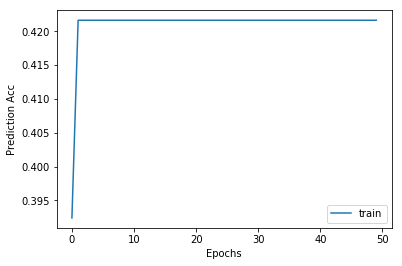

In [50]:
plt.plot(train_acc, label = 'train')
plt.xlabel('Epochs')
plt.ylabel('Training Acc')
# plt.title('Losses curve on (500 *0.7) training dataset')
plt.legend()
plt.show()

## ResNet: classification
Successfully overfit training.

### Resnet models
Subtle change from 3 to 2 input channels.

In [6]:
# __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
#            'resnet152']


# model_urls = {
#     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
#     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
#     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
#     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
# }


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        ###
        ### change 3 to 2 for our data
        ###
        self.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model



def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model



def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model



def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

### resnetTCData: Dataset object
Loading from npy file needs np.moveaxis command.

In [51]:
class resnetTCData(data.Dataset):

    def __init__(self, dataPath, infoPath, transform=None):
        super(resnetTCData, self).__init__()
        # load data from npy file
        # classical way of loading data: read in every thing and then index
        # 238s for one epoch on mbp
        # self.data = np.load(dataPath)
        # new way: no self.data pre-read, load in file in the fly
        # instead storing data, we look up by label in train or val
        self.dataLabel = dataPath.split('.')[0]
        # 236s for one epoch on mbp
        # load label from npy file with pandas dataframe
        self.target = np.load(infoPath)
        # transform as defined outside
        self.transform = transform
        self.targetDic = {
            'no':0, 'td':1, 'ts':2, 'one':3, 'two':4, 'three':5, 'four':6, 'five':7
        }

    def __getitem__(self, index):
        # middle crop and permute axis
        # we found that in the later cell, there is a "center crop" transform
        # if the transforms.centercrop() works, then no need for 68:(68+64)
        
        # classical way of loading data: read in every thing and then index
        # 238s for one epoch on mbp
        # datMatrix = torch.from_numpy(np.moveaxis(self.data[index, :, :, [0, 3]], 0, -1)).float()
        
        # new way: no self.data pre-read, load in file in the fly according to the label
        # 236s to train one epoch on mbp
        dat = np.load('./data/' + self.dataLabel + '_{}.npy'.format(index))
        datMatrix = torch.from_numpy(dat[:, :, [0, 3]]).float()
        
        datMatrix = np.nan_to_num(datMatrix)
        datMatrix[datMatrix > 1000] = 0
#         print(index)
        # print(datMatrix.shape)
        if self.transform:
            datMatrix = self.transform(datMatrix)
        
        labMatrix = self.target[index]
        
        return (datMatrix, labMatrix)

    def __len__(self):
        # classical way of returning length of dataset
        # return self.data.shape[0]
    
        # new way: count how many files in the current dir with same prefix
        return len([f for f in os.listdir('./data/') 
                    if os.path.isfile(os.path.join('./data/', f)) and f.split('_')[0] == self.dataLabel])

### Prepare for learning
+ Transformation;
+ Data set object;
+ Dataloaders of datasets;
+ Criterion in loss;

In [52]:
# trainData = np.load('train.npy')
transf = {
    'mean': (267.81773236, 0.48700156),
    'std': (27.09388376,  1.47568378)
}

data_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=transf['mean'], std=transf['std']) 
    # transforms.CenterCrop(64)
])

# old info files are in .h5
# new are in npy
datasets = {x: resnetTCData('{}.npy'.format(x), '{}Info.npy'.format(x), data_transform) 
            for x in ['train', 'val']}
dataloaders = {x: DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

### Train function: classification
Train model with cross entropy loss (or equivalently, softmax loss).

In [53]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #print(outputs, loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                print(preds)
                print(labels.data)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                training_acc.append(epoch_acc)
            else:
                val_acc.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print('Elapsed: {:.4f}'.format(time.time() - since))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_acc, val_acc

### resnetTC: learning
Can use any resnet model difined above.

In [54]:
labels = ['no', 'td', 'ts', 'one', 'two', 'three', 'four', 'five']
resnetTC = resnet18(num_classes = 8, pretrained=False)
resnetTC = resnetTC.to(device)

optimizer = optim.Adam(resnetTC.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
#                                                  patience = 5, threshold = 0.01, 
#                                                  factor = 1/3, threshold_mode  = 'rel')
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.33)

_, train_acc, val_acc  = train_model(resnetTC, criterion, optimizer, scheduler, num_epochs=100)


Epoch 0/49
----------
tensor([1, 1, 5, 5, 5, 1, 5, 4, 1, 1, 6, 4, 6, 4, 4, 1, 1, 1, 5, 4, 4, 1, 1, 1,
        4, 1, 1, 7, 4, 5, 1, 5])
tensor([2, 3, 2, 1, 6, 2, 3, 3, 5, 2, 2, 2, 2, 2, 2, 6, 2, 3, 3, 4, 2, 2, 2, 6,
        2, 2, 2, 2, 2, 2, 6, 2])
tensor([2, 2, 2, 1, 2, 1, 1, 2, 2, 3, 3, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1,
        2, 2, 2, 3, 3, 3, 2, 1])
tensor([6, 4, 3, 2, 1, 2, 2, 1, 2, 3, 2, 4, 2, 6, 7, 6, 4, 2, 6, 6, 6, 7, 5, 3,
        4, 1, 2, 2, 2, 2, 6, 3])
tensor([2, 6, 6, 6, 6, 2, 2, 2, 2, 2, 6, 2, 6, 6, 6, 2, 6, 6, 2, 2, 2, 6, 2, 6,
        2, 6, 2, 2, 2, 6, 2, 2])
tensor([2, 1, 7, 2, 2, 2, 3, 2, 2, 4, 4, 2, 3, 4, 6, 2, 7, 3, 6, 6, 1, 7, 3, 1,
        6, 2, 2, 4, 3, 2, 7, 2])
tensor([2, 2, 2, 2, 6, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 2, 6, 2, 2,
        2, 2, 2, 2, 2, 2, 6, 3])
tensor([1, 5, 2, 1, 5, 2, 2, 2, 1, 3, 2, 5, 2, 7, 2, 4, 2, 2, 2, 3, 2, 6, 2, 2,
        5, 3, 6, 6, 6, 1, 4, 3])
tensor([2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([7, 2, 2, 4, 2, 2, 6, 2, 5, 2, 7, 3, 2, 6, 6, 6, 2, 7, 4, 3, 4, 2, 4, 3,
        4, 6, 3, 5, 7, 3, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 3, 3, 2, 6, 4, 2, 2, 3, 1, 4, 3, 3, 2, 7, 2, 2, 2, 2,
        3, 2, 1, 7, 6, 6, 2, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([5, 2, 2, 3, 2, 5, 2, 6, 2, 3, 2, 2, 2, 7, 2, 7, 2, 2, 7, 2, 2, 1, 4, 6,
        7, 2, 3, 3, 1, 2, 2, 4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([4, 2, 3, 2, 6, 1, 1, 1, 3, 1, 2, 6, 4, 6, 6, 6, 2, 2, 2, 1, 2, 3, 7, 2,
        5, 3, 2, 2, 5, 2, 5, 2])
tensor([2, 2])
tensor([2, 2])
val Loss: 1.8867 Acc: 0.4147
Elapsed: 236.2311

Epoch 1/49
-------

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shuyiyin/anaconda/envs/cs231n/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shuyiyin/anaconda/envs/cs231n/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/shuyiyin/anaconda/envs/cs231n/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/shuyiyin/anaconda/envs/cs231n/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/shuyiyin/anaconda/envs/cs231n/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shuyiyin/anaconda/envs/cs231n/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + 

KeyboardInterrupt: 

In [ ]:
plt.plot(train_acc, label = 'train')
plt.plot(val_acc, label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Training Acc')
plt.legend()
plt.show()

# Playground: before everything

### Load in data from h5py

In [ ]:
# data_path = "TCIR-ALL_2017.h5"

# load "info" as pandas dataframe
data_info = pd.read_hdf("TCIR-ALL_2017.h5", key="info", mode='r')
ylabel17 = list(data_info['Vmax'])

ylabel1216 = []
data_info = pd.read_hdf("TCIR-ATLN_EPAC_WPAC.h5", key="info", mode='r')
ylabel1216 += list(data_info['Vmax'])

data_info = pd.read_hdf("TCIR-CPAC_IO_SH.h5", key="info", mode='r')
ylabel1216 += list(data_info['Vmax'])

# load "matrix" as numpy ndarray, this could take longer times
# with h5py.File(data_path, 'r') as hf:
#     data_matrix = hf['matrix'][:]

### A sketch of label matrix
Vmax is wind speed, MSLP is minimum sea level pressure, R35_4qAVG is radius.

In [ ]:
data_path = "TCIR-CPAC_IO_SH.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [ ]:
data_info.iloc[0:50]

### Several visualizations

In [ ]:
plt.figure()
plt.hist(ylabel17, 20)
plt.xlabel(r'Intensity of TCs'+'\n' + '(maximum sustained wind, $V_{max}$, in knots)')
plt.ylabel(r'Frequency counts')
plt.savefig('1')
plt.figure()
plt.hist(ylabel1216, 20)
plt.xlabel(r'Intensity of TCs'+'\n' + '(maximum sustained wind, $V_{max}$, in knots)')
plt.ylabel(r'Frequency counts')
plt.savefig('2')

In [ ]:
plt.plot(data_info.loc[data_info['ID'] == '201733W']['Vmax'])
plt.show()

In [ ]:
plt.imshow(data_matrix[0,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[1,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[2,:,:,0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(data_matrix[10,:,:,0], cmap='gray')
plt.show()

### Rotate: trial
Problematic: except 90, 180, 270, 360 degrees, rotations of all other degrees have incorrect outputs: whitening

In [ ]:
skimage.transform.rotate(data_matrix[0, :, :, :], 10).shape

In [ ]:
plt.hist(data_matrix[0, :, :, 0].flatten(), 100)
plt.show()

In [ ]:
plt.hist(skimage.transform.rotate(data_matrix[0, :, :, 0], 1, preserve_range=True).flatten(), 100)
plt.show()

In [ ]:
import scipy
plt.hist(scipy.ndimage.rotate(data_matrix[0, :, :, 0], 1).flatten(), 100)
plt.show()

In [ ]:
plt.imshow(data_matrix[0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
plt.imshow(skimage.transform.rotate(data_matrix[0, :, :, 0], 90, preserve_range=True), cmap='gray')
plt.show()

In [ ]:
np.max(data_matrix[0, :, :, 0])

In [ ]:
np.max(skimage.transform.rotate(data_matrix[0, :, :, 0], 10, preserve_range=True))

### Check how many in matrix is nan
Must deal with data outlier as proposed in paper

In [ ]:
np.prod(data_matrix.shape)

In [ ]:
count = 0
for i in range(data_matrix.shape[0]):
    if np.count_nonzero(np.isnan(data_matrix[i, :, :, :])) > 0:
        count += 1
print(count)
print(data_matrix.shape[0])

### Show h5df file content and play with data load step

In [29]:
def h5printR(item, leading = ''):
    for key in item:
        if isinstance(item[key], h5py.Dataset):
            print(leading + key + ': ' + str(item[key].shape))
        else:
            print(leading + key)
            h5printR(item[key], leading + '  ')

# Print structure of a `.h5` file            
def h5print(filename):
    with h5py.File(filename, 'r') as h:
        print(filename)
        h5printR(h, '  ')

In [37]:
x = pd.read_hdf('trainInfo.h5')

ValueError: The file 'trainInfo.h5' is already opened, but not in read-only mode (as requested).

# Calculate channel mean and std in rolling manner
### Test set: 2017 all
### Training + Validation: 2012-2016 two files
#### 80% training, 20% validation, sample the first set
+ ATLN_EPAC_WPAC: $ 47381 \times 0.8 = 37900$
+ CPAC_IO_SH: $23118\times 0.8 = 18500$

In [ ]:
data_path = "TCIR-ATLN_EPAC_WPAC.h5"

# load "info" as pandas dataframe
data_info = pd.read_hdf(data_path, key="info", mode='r')

# load "matrix" as numpy ndarray, this could take longer times
total = np.zeros((379 + 185,4))
sqd = np.zeros((379 + 185,4))

with h5py.File("TCIR-ATLN_EPAC_WPAC.h5", 'r') as hf:
    data_matrix = hf['matrix'][:]

    for i in range(37900 // 100):
        local = np.nan_to_num(data_matrix[i * 100: (i+1)*100, :, :, :])
        local[local > 1000] = 0
        total[i,:] =  np.sum(local / ((379 + 185) * 100 * 201 * 201), axis = (0, 1, 2))
        sqd[i,:] =  np.sum(local ** 2 / ((379 + 185) * 100 * 201 * 201), axis = (0, 1, 2))
        
with h5py.File("TCIR-CPAC_IO_SH.h5", 'r') as hf:
    data_matrix = hf['matrix'][:]

    for i in range(18500 // 100):
        local = np.nan_to_num(data_matrix[i * 100: (i+1)*100, :, :, :])
        local[local > 1000] = 0
        total[37900 // 100 + i,:] =  np.sum(local / ((379 + 185) * 100 * 201 * 201), axis = (0, 1, 2))
        sqd[37900 // 100 + i,:] =  np.sum(local ** 2 / ((379 + 185) * 100 * 201 * 201), axis = (0, 1, 2))

### Channel average

In [ ]:
EX = np.sum(total, axis = 0) #  / ((379 + 185) * 100 * 201 * 201)
print(EX)

In [ ]:
plt.plot(np.cumsum(total, axis = 0))
plt.legend(('0-IR','1-WV','2-VIS','3-PMW'))
plt.title(r'Channel $1^{st}$ moment: $E[X]$')
plt.show()

### Channel std

In [ ]:
EX2 = np.sum(sqd, axis = 0)
print(EX2)

In [ ]:
var = EX2 - EX ** 2
std = var ** 0.5
print(var)
print(std)

In [ ]:
plt.plot(np.cumsum(sqd, axis = 0))
plt.legend(('0-IR','1-WV','2-VIS','3-PMW'))
plt.title(r'Channel $2^{nd}$ moment: $E[X^2]$')
plt.show()